In [3]:
# 線形回帰の参考資料(P297~P311)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages')
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
#「sep = \s+」は、もとのデータの区切りがスペースであり、スペースが複数個続いていることを示している

df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PIRATIO','B','LSTAT','MEDV']
#カラムの名前を指定

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PIRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


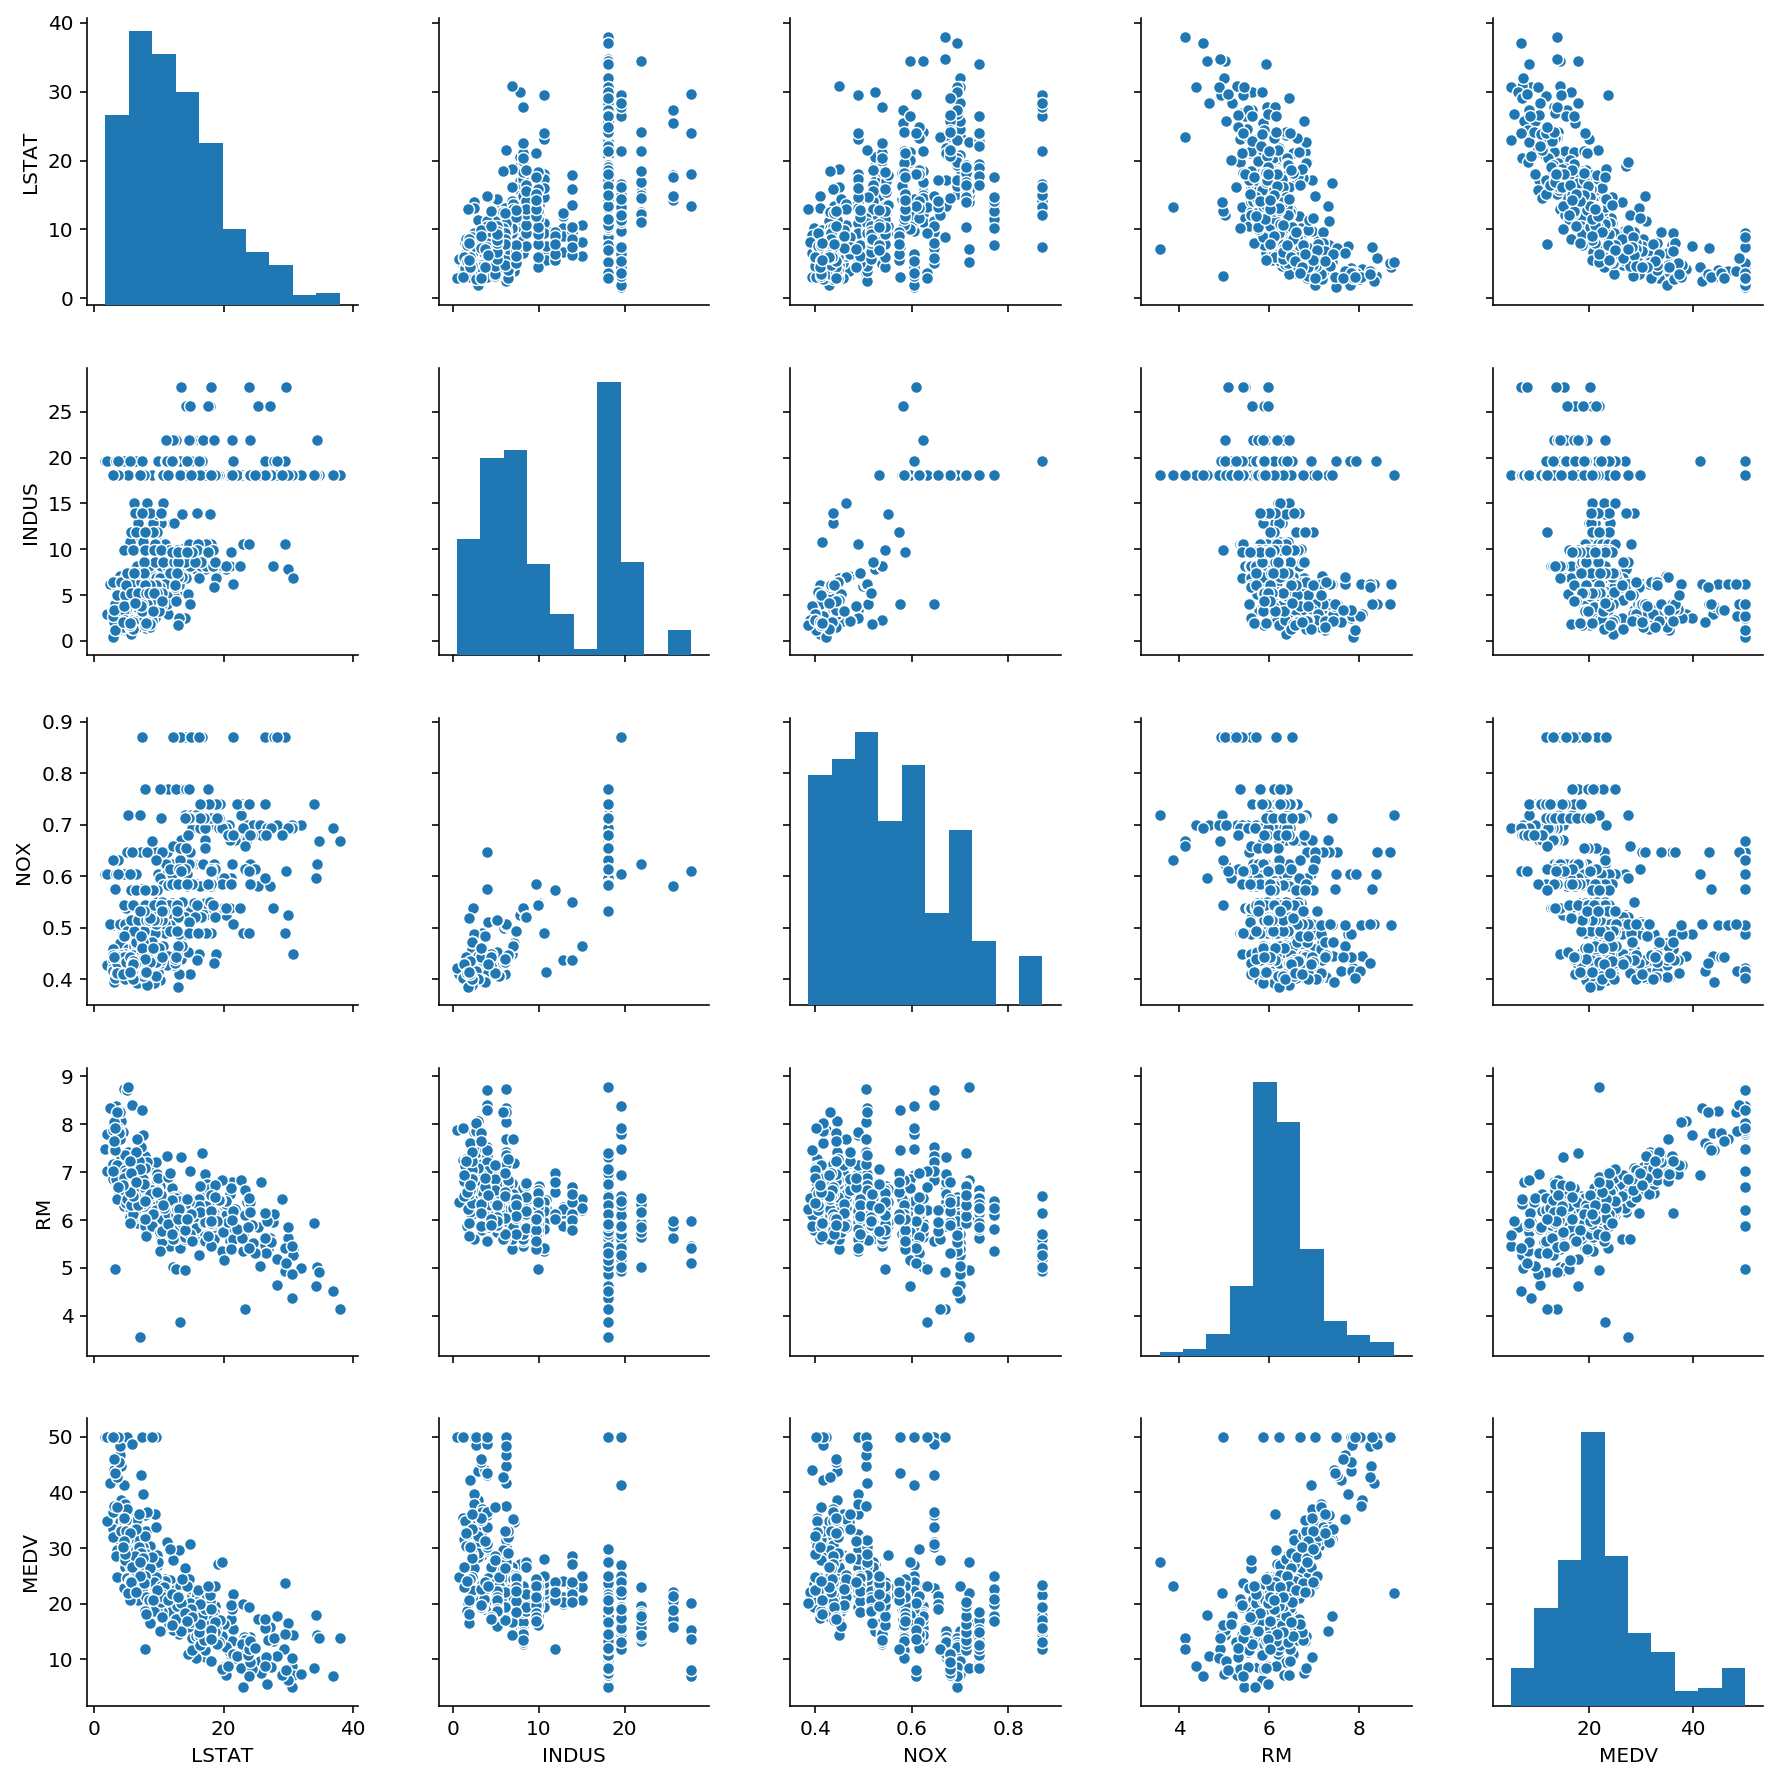

In [6]:
# データセットの可視化
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
# 変数のペアの関係をプロット：dfはDataFrameオブジェクト、sizeは1面のインチサイズ
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

In [8]:
# 目的変数MEDVに対し、相関係数が大きいものは、RMとLSTATである。※相関係数の算出は省略(P305を参照)
# LSTAT(1行5列目)は、非線形であることがわかる
# RM(4行5列目)とMEDVは、線形であることがわかるため、以下では線形モデルの実装を行なう

class LinearRegressionGD(object):
    # 初期化
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta # 学習率
        self.n_iter = n_iter # トレーニング回数
    
    # トレーニングを実行する def fit
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1]) # 重みを初期化
        self.cost_ = [] # コスト関数の値を初期化
    
        for i in range(self.n_iter):
            output = self.net_input(X) # 活性化関数の出力を計算
            errors = (y - output) # 誤差を計算
            self.w_[1:] += self.eta * X.T.dot(errors) # 重みw_{1}以降を更新
            self.w_[0] += self.eta * errors.sum() # 重みw_{0}を更新
            cost = (errors**2).sum() / 2.0 # コスト関数を計算
            self.cost_.append(cost) # コスト関数の値を格納
        return self

    # 総入力を計算する net_input
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    # 予測値を計算する predict
    def predict(self, X):
        return self.net_input(X)

In [9]:
# LinearRegressionGD回帰の実際の動作を確認するために、HousingデータセットのMEDV(住宅価格の中央値)を予測するモデルをトレーニングする
# 今回は、説明変数としてRM(1戸あたりの平均部屋数)を使用する
X = df[['RM']].values # 部屋数のデータを読み込み
y = df[['MEDV']].values # 住宅価格の中央値データを読み込み
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LinearRegression
sc_x = StandardScaler() # 標準化
sc_y = StandardScaler() # 標準化
X_std = sc_x.fit_transform(X) # パラメータ計算とデータ変換を同時に実行
y = y.flatten() # 何故か必要
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
# y[:, np.newaxis]:縦ベクトルに変換、.flatten():1次元配列に変換
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

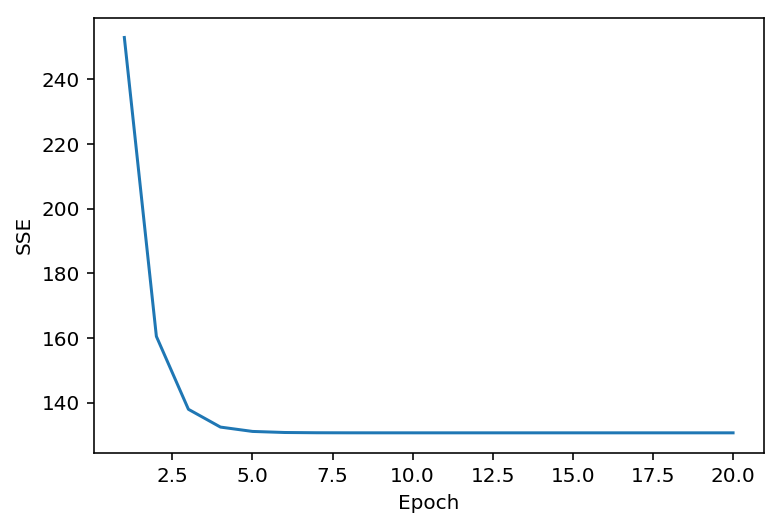

In [10]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()
# 勾配降下法などの最適化アルゴリズムを使用する際は、コストの最小値に収束することを確認するために、
# コストをエポック数(データセットのトレーニング回数)の関数としてプロットすると良い
# 下記の例では、5回のエポックのあとに収束していることがわかる

In [12]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
# ロバスト回帰モデルのクラスをインスタンス化
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100, # RANSACRegressorのイテレーションの最大値を100
                         min_samples=50, # ランダムに選択されるサンプルの最小数を50に設定
                         loss='absolute_loss', # lossパラメータの値として、absolute_lossを指定することで
                         # 学習直線に対するサンプル点の縦の距離の絶対値を計算させている
                         residual_threshold=5.0, # 5を指定することで、学習直線に対する縦の距離が5単位距離内のサンプル点だけが正常値に含まれるようにしている
                         random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

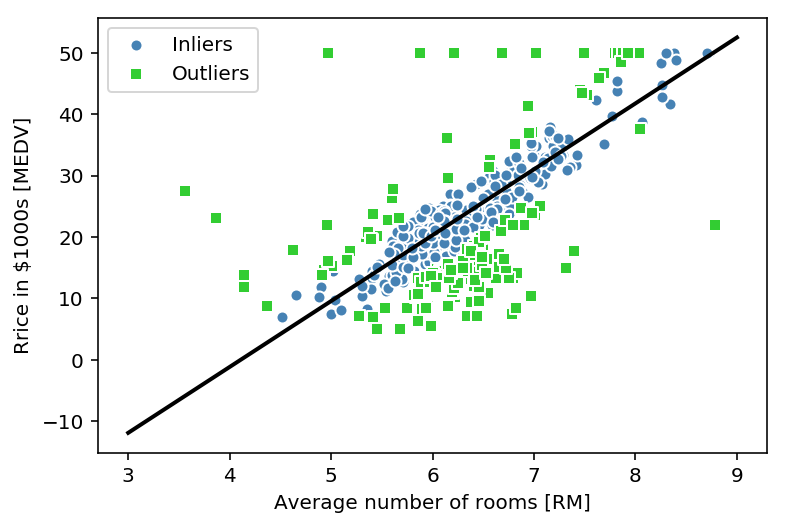

In [16]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
# 正常値をプロット
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', marker='o', label='Inliers')
# 外れ値をプロット
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', marker='s', label='Outliers')
# 予測値をプロット
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Rrice in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()